# SMAI Assignment - 3

## Question - `3` : Knowing MLPs

| | |
|- | -|
| Course | Statistical Methods in AI |
| Release Date | `09.03.2023` |
| Due Date | `24.03.2023` |

## Please read the following before moving on

Welcome to the world of Multilayer Perceptrons (MLP)! You already know that MLPs are feedforward neural networks consisting of multiple layers of nodes or neurons. These networks are well-suited for a wide range of classification and regression tasks, thanks to their ability to learn complex, non-linear relationships between inputs and outputs.

In this assignment, we will be working with the MNIST dataset to explore the importance of different MLP components. The MNIST dataset consists of 70,000 handwritten digit images, each of which is 28x28 pixels in size. Our goal is to use an MLP to classify these images into one of 10 categories (0-9).

To improve the performance of our MLP, we will experiment with various techniques such as Dropout, Batch Normalization, Loss Functions, Stochastic batch and mini-batch gradient descent, and more. Please note, you must use mini-batch unless explicity specified.

In addition, we will experiment with different optimization algorithms such as stochastic gradient descent, Adam, and RMSprop to find the optimal weights and biases for our MLP. We will use stochastic batch and mini-batch gradient descent, which involve updating the weights and biases of the network based on a small batch of randomly sampled training examples, to speed up the training process and reduce memory usage.

By the end of this assignment, you will have gained a deeper understanding of the various components that make up an MLP and their importance in achieving high performance in classification tasks. You will have gained hands-on experience in experimenting with these components and learned how to fine-tune an MLP to achieve the best possible performance on the MNIST dataset. So, let's get started!

🫵Pro-tip: Do not re-write any results so as to re-use them in later experiments for tabulation and plotting.

💭Trivia: Did you know code written using ChatGPT is easy to catch?

### Step zero: Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline
from time import time
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
from torch import nn, optim

### Step one: Using a PyTorch Dataset
Load MNIST dataset from `torchvision.datasets`

In [2]:
transform = transforms.Compose([
                    transforms.ToTensor(), 
            ])

trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
testset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/train-images-idx3-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/train-labels-idx1-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/t10k-images-idx3-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TRAINSET/MNIST/raw/t10k-labels-idx1-ubyte.gz to PATH_TO_STORE_TRAINSET/MNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TESTSET/MNIST/raw/train-images-idx3-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TESTSET/MNIST/raw/train-labels-idx1-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TESTSET/MNIST/raw/t10k-images-idx3-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting PATH_TO_STORE_TESTSET/MNIST/raw/t10k-labels-idx1-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw



In [3]:
trainloader_minibatch = torch.utils.data.DataLoader(trainset, batch_size=64  , shuffle=True, num_workers=2)
                                                  
trainloader_stochastic = torch.utils.data.DataLoader(trainset, batch_size=1 , shuffle=True, num_workers=2 )  
                                                               
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


In [4]:
from tqdm import trange, tqdm

pbar = tqdm(total=len(trainloader_minibatch))

for idx, (data,label) in enumerate(trainloader_minibatch):
    print(idx,data.size(),label.size())
    pbar.update(1)
    break
pbar.refresh()

  0%|          | 1/938 [00:00<04:34,  3.41it/s]

0 torch.Size([64, 1, 28, 28]) torch.Size([64])


True

### Step two: Define a MLP Model and without any bells and whitsles...
... along with a CrossEntropy loss criterion 

Do not use Dropout, BN or any other thing. Use ReLU for hidden layers.

⚠️ Do not use SoftMax in the output as nn.CrossEntropyLoss combines SoftMax and NLLLoss.

In [5]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP,self).__init__()
        self.linear1 = nn.Linear(28*28, 100) 
        self.linear2 = nn.Linear(100, 50) 
        self.final = nn.Linear(50, 10)
        self.relu = nn.ReLU()

    def forward(self, img): #convert + flatten
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.final(x)
        return x
mlp = SimpleMLP()

In [6]:
cross_el = nn.CrossEntropyLoss()

### Step three: Define the following optimizers using nn.optim
1. SGD
2. SGD with momentum
3. SGD with L2 regularization
4. RMSprop
5. Adam

In [7]:
def runOptimizer(optimizer,model,trainset,testset,scheduler=None):

    trainLoss = []
    testLoss = []
    time0 = time()
    epochs = 10
    model.train()
    for e in range(epochs):

        if scheduler!=None:
            scheduler.step()

        runningLoss = 0
        for images, labels in trainset:
            images = images.view(images.shape[0], -1)
            optimizer.zero_grad()
            output = model(images)
            loss = cross_el(output, labels)
            loss.backward()
            optimizer.step()
            runningLoss =runningLoss + loss.item()
        else:
            trainLoss.append(runningLoss/len(trainset))
            
        with torch.no_grad():
        
            outLoss = 0
             
            for batch_idx, (data, target) in enumerate(testset):
                 
                if torch.cuda.is_available():
                    data, target = data.cuda(), target.cuda()
                 
                output = model(data)
                loss = cross_el(output, target)
                 
                outLoss =outLoss + loss.cpu().item()
            
            testLoss.append(outLoss / len(testset))
         
    t=(time()-time0)/60
    return trainLoss,testLoss,t

SGD

In [8]:
mlp1=SimpleMLP()
optimizer1 = optim.SGD(mlp1.parameters(), lr=0.003)


SGD with momentum

In [9]:
mlp2=SimpleMLP()
optimizer2 = optim.SGD(mlp2.parameters(), lr=0.003, momentum=0.9)


SGD with L2 regularization

In [10]:
mlp3=SimpleMLP()
optimizer3 = optim.SGD(mlp3.parameters(), lr=0.003,weight_decay=0.001)


RMSprop

In [11]:

mlp4=SimpleMLP()

optimizer4=optim.RMSprop(mlp4.parameters(), lr=0.003, alpha=0.003, eps=1e-08)



ADAM

In [12]:
 
mlp5=SimpleMLP()
optimizer5 = torch.optim.Adam(mlp5.parameters(), lr=0.003) #e-1
 

### Step four: Run the SimpleMLP using different optimizers and plot train and test loss for each optimizer.
Explain the results.

Report final accuracy, F1 score and other relavant metrics in a tabular form on test and train datasets.

In [13]:
 
def plot(x,y):
    plt.plot(x, label = "training loss", linestyle='dashed')
    plt.plot(y, label = "testing loss")
    plt.legend()
    plt.show()


def accuracy(dataset,model):
    correct=0
    total=0
    with torch.no_grad():
        
        for data in dataset:
            x, y = data
            output = model(x.view(-1, 784))
            for idx, i in enumerate(output):
                
                if torch.argmax(i) == y[idx]:
                    correct +=1
                total +=1
    ans=np.round(correct/total, 3)
    return ans

def make_predictions(data_loader,model):
    model.eval()
    test_preds = torch.LongTensor()
    actual_labels = torch.LongTensor()
    for i, (data, target) in enumerate(data_loader):
        actual_labels = torch.cat((actual_labels, target), dim=0)
        data = data.unsqueeze(1)
        
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = model(data)
        
        preds = output.cpu().data.max(1, keepdim=True)[1]
        test_preds = torch.cat((test_preds, preds), dim=0)
         
    return test_preds,actual_labels



SGD

In [14]:
 
train_loss1,test_loss1,t=runOptimizer(optimizer1,mlp1,trainloader_minibatch,testloader)


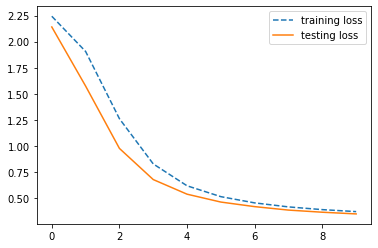

In [15]:
plot(train_loss1,test_loss1)

In [16]:
a11=accuracy(trainloader_minibatch,mlp1)
a12=accuracy(testloader,mlp1)
print(a11)
print(a12)

0.899
0.9


In [17]:
train_set_preds,actual_train= make_predictions(trainloader_minibatch,mlp1)
test_set_preds,actual_test = make_predictions(testloader,mlp1)


from sklearn.metrics import f1_score
f11=f1_score(actual_train, train_set_preds, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn')
f12=f1_score(actual_test, test_set_preds, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn')
print(f11)
print(f12)

0.8986
0.9


SGD with momentum

In [18]:

train_loss2,test_loss2,t=runOptimizer(optimizer2,mlp2,trainloader_minibatch,testloader)


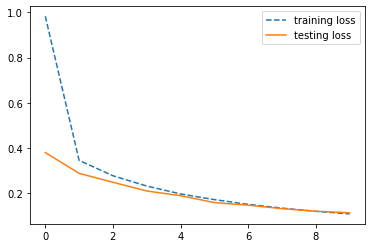

In [19]:

plot(train_loss2,test_loss2)

In [20]:
a21=accuracy(trainloader_minibatch,mlp2)
a22=accuracy(testloader,mlp2)
print(a21)
print(a22)

0.972
0.966


In [21]:
train_set_preds,actual_train= make_predictions(trainloader_minibatch,mlp2)
test_set_preds,actual_test = make_predictions(testloader,mlp2)


from sklearn.metrics import f1_score
f21=f1_score(actual_train, train_set_preds, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn')
f22=f1_score(actual_test, test_set_preds, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn')
print(f21)
print(f22)

0.9722
0.9665


SGD with L2 regularization

In [22]:

train_loss3,test_loss3,t=runOptimizer(optimizer3,mlp3,trainloader_minibatch,testloader)


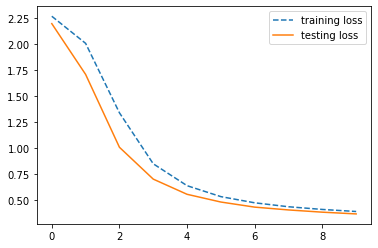

In [23]:

plot(train_loss3,test_loss3)

In [24]:
a31=accuracy(trainloader_minibatch,mlp3)
a32=accuracy(testloader,mlp3)
print(a31)
print(a32)

0.895
0.898


In [25]:
train_set_preds,actual_train= make_predictions(trainloader_minibatch,mlp3)
test_set_preds,actual_test = make_predictions(testloader,mlp3)


from sklearn.metrics import f1_score
f31=f1_score(actual_train, train_set_preds, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn')
f32=f1_score(actual_test, test_set_preds, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn')
print(f31)
print(f32)

0.89465
0.8985


RMSProp

In [26]:

train_loss4,test_loss4,t=runOptimizer(optimizer4,mlp4,trainloader_minibatch,testloader)


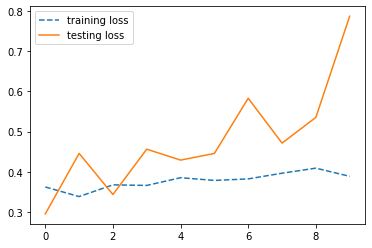

In [27]:

plot(train_loss4,test_loss4)

In [28]:
a41=accuracy(trainloader_minibatch,mlp4)
a42=accuracy(testloader,mlp4)
print(a41)
print(a42)

0.964
0.954


In [29]:
train_set_preds,actual_train= make_predictions(trainloader_minibatch,mlp4)
test_set_preds,actual_test = make_predictions(testloader,mlp4)


from sklearn.metrics import f1_score
f41=f1_score(actual_train, train_set_preds, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn')
f42=f1_score(actual_test, test_set_preds, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn')
print(f41)
print(f42)

0.9635
0.9537


ADAM

In [30]:

train_loss5,test_loss5,t=runOptimizer(optimizer5,mlp5,trainloader_minibatch,testloader)


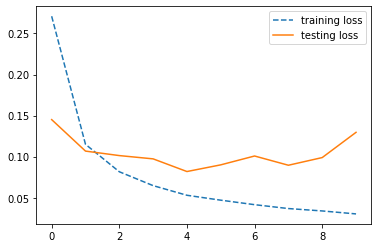

In [31]:

plot(train_loss5,test_loss5)

In [32]:
a51=accuracy(trainloader_minibatch,mlp5)
a52=accuracy(testloader,mlp5)
print(a51)
print(a52)

0.987
0.97


In [33]:
train_set_preds,actual_train= make_predictions(trainloader_minibatch,mlp5)
test_set_preds,actual_test = make_predictions(testloader,mlp5)


from sklearn.metrics import f1_score
f51=f1_score(actual_train, train_set_preds, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn')
f52=f1_score(actual_test, test_set_preds, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn')
print(f51)
print(f52)

0.9866666666666668
0.9695


In [34]:
from prettytable import PrettyTable
table = PrettyTable(["Optimizer", "Train Accuracy", "Test Accuracy", "F1 score train", "F1 score test"])
table.align = 'l'
table.add_row(["SGD", a11, a12, f11, f12])
table.add_row(["SGD with momentum", a21, a22, f21, f22])
table.add_row(["SGD with L2 regularization", a31, a32, f31, f32])
table.add_row(["RMSProp", a41, a42, f41, f42])
table.add_row(["Adam", a51, a52, f51, f52])



In [35]:
print(table)

+----------------------------+----------------+---------------+--------------------+---------------+
| Optimizer                  | Train Accuracy | Test Accuracy | F1 score train     | F1 score test |
+----------------------------+----------------+---------------+--------------------+---------------+
| SGD                        | 0.899          | 0.9           | 0.8986             | 0.9           |
| SGD with momentum          | 0.972          | 0.966         | 0.9722             | 0.9665        |
| SGD with L2 regularization | 0.895          | 0.898         | 0.89465            | 0.8985        |
| RMSProp                    | 0.964          | 0.954         | 0.9635             | 0.9537        |
| Adam                       | 0.987          | 0.97          | 0.9866666666666668 | 0.9695        |
+----------------------------+----------------+---------------+--------------------+---------------+


### Step five: Using SimpleMLP and Adam optimizer, train models using 2 different lr_schedulers.
Select 2 of **MultiplicativeLR**, **MultiStepLR**, **LinearLR** and **ExponentialLR**

Compare the results among different LR schedulers and the original model which didn't employ any LR scheduler. Compile results in a tabular form. Plot losses for each. Explain results.

ExponentialLR

In [36]:
from torch.optim.lr_scheduler import MultiStepLR
from torch.optim.lr_scheduler import ExponentialLR

mlp1 = SimpleMLP()
cross_el = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp1.parameters(), lr=0.003) #e-1
epoch = 10
scheduler1 = ExponentialLR(optimizer, gamma=0.9)



In [37]:
train_loss1,test_loss1,t=runOptimizer(optimizer,mlp1,trainloader_minibatch,testloader,scheduler1)

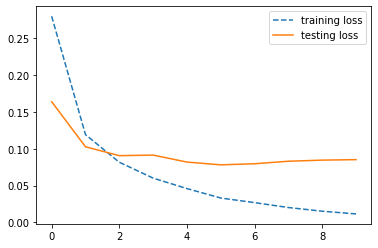

In [38]:

plot(train_loss1,test_loss1)

In [39]:
a11=accuracy(trainloader_minibatch,mlp1)
a12=accuracy(testloader,mlp1)
print(a11)
print(a12)

0.998
0.979


In [40]:
train_set_preds,actual_train= make_predictions(trainloader_minibatch,mlp1)
test_set_preds,actual_test = make_predictions(testloader,mlp1)


from sklearn.metrics import f1_score
f11=f1_score(actual_train, train_set_preds, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn')
f12=f1_score(actual_test, test_set_preds, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn')
print(f11)
print(f12)

0.9976166666666667
0.9787


MultiStepLR

In [41]:
mlp2 = SimpleMLP()
cross_el = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp2.parameters(), lr=0.003) #e-1
scheduler2 = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

In [42]:
train_loss2,test_loss2,t=runOptimizer(optimizer,mlp2,trainloader_minibatch,testloader,scheduler2)

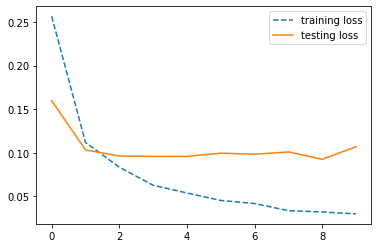

In [43]:

plot(train_loss2,test_loss2)

In [44]:
a21=accuracy(trainloader_minibatch,mlp2)
a22=accuracy(testloader,mlp2)
print(a21)
print(a22)

0.991
0.975


In [45]:
train_set_preds,actual_train= make_predictions(trainloader_minibatch,mlp2)
test_set_preds,actual_test = make_predictions(testloader,mlp2)


from sklearn.metrics import f1_score
f21=f1_score(actual_train, train_set_preds, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn')
f22=f1_score(actual_test, test_set_preds, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn')
print(f21)
print(f22)

0.9912833333333333
0.9749


In [46]:

table = PrettyTable(["Optimizer", "Train Accuracy", "Test Accuracy", "F1 score train", "F1 score test"])
table.align = 'l'
table.add_row(["Simple Adam", a51, a52, f51, f52])
table.add_row(["Adam with ExponentialLR", a11, a12, f11, f12])
table.add_row(["Adam with MultiStepLR", a21, a22, f21, f22])


In [47]:
print(table)

+-------------------------+----------------+---------------+--------------------+---------------+
| Optimizer               | Train Accuracy | Test Accuracy | F1 score train     | F1 score test |
+-------------------------+----------------+---------------+--------------------+---------------+
| Simple Adam             | 0.987          | 0.97          | 0.9866666666666668 | 0.9695        |
| Adam with ExponentialLR | 0.998          | 0.979         | 0.9976166666666667 | 0.9787        |
| Adam with MultiStepLR   | 0.991          | 0.975         | 0.9912833333333333 | 0.9749        |
+-------------------------+----------------+---------------+--------------------+---------------+


### Step six: Define 3 models with following changes:
1. Add BatchNorm
2. Add Dropout
3. Add BatchNorm and Dropout

In [48]:

class BatchMLP(nn.Module):
    def __init__(self):
        super(BatchMLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.bn1 = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, 50)
        self.bn2 = nn.BatchNorm1d(50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        output = self.fc3(x)
        return output


class DropoutMLP(nn.Module):
    def __init__(self):
        super(DropoutMLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(100, 50)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(50, 10)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        output = self.fc3(x)
        return output

class BatchDropoutMLP(nn.Module):
    def __init__(self):
        super(BatchDropoutMLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 100)
        self.bn1 = nn.BatchNorm1d(100)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(100, 50)
        self.bn2 = nn.BatchNorm1d(50)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        output = self.fc3(x)
        return output


### Step seven: Train the above models and compare with SimpleMLP.

Use your choice of optimizer, use no lr_scheduler so as to re-use the previous results.

Perform analysis. You've got the drill by now.

BatchNorm

In [49]:
batchmlp=BatchMLP()
optimizer = torch.optim.Adam(batchmlp.parameters(), lr=0.003) #e-1
train_loss1,test_loss1,t=runOptimizer(optimizer,batchmlp,trainloader_minibatch,testloader)


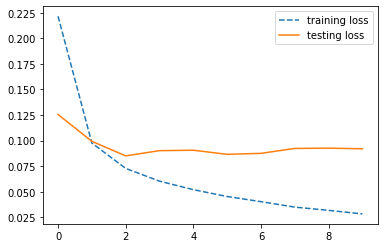

In [50]:

plot(train_loss1,test_loss1)

In [51]:
a21=accuracy(trainloader_minibatch,batchmlp)
a22=accuracy(testloader,batchmlp)
print(a21)
print(a22)  

0.991
0.974


In [52]:
train_set_preds,actual_train= make_predictions(trainloader_minibatch,batchmlp)
test_set_preds,actual_test = make_predictions(testloader,batchmlp)


from sklearn.metrics import f1_score
f21=f1_score(actual_train, train_set_preds, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn')
f22=f1_score(actual_test, test_set_preds, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn')
print(f21)
print(f22)

0.9949333333333333
0.9777


Dropout

In [53]:
dropoutmlp=DropoutMLP()
optimizer = torch.optim.Adam(dropoutmlp.parameters(), lr=0.003) #e-1
train_loss2,test_loss2,t=runOptimizer(optimizer,dropoutmlp,trainloader_minibatch,testloader)

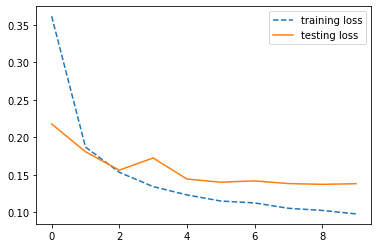

In [54]:

plot(train_loss2,test_loss2)

In [55]:
a31=accuracy(trainloader_minibatch,dropoutmlp)
a32=accuracy(testloader,dropoutmlp)
print(a31)
print(a32)  

0.973
0.965


In [56]:
train_set_preds,actual_train= make_predictions(trainloader_minibatch,dropoutmlp)
test_set_preds,actual_test = make_predictions(testloader,dropoutmlp)


from sklearn.metrics import f1_score
f31=f1_score(actual_train, train_set_preds, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn')
f32=f1_score(actual_test, test_set_preds, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn')
print(f31)
print(f32)

0.98765
0.9764


Batchnorm and Dropout

In [57]:
batchdropoutmlp=BatchDropoutMLP()
optimizer = torch.optim.Adam(batchdropoutmlp.parameters(), lr=0.003) #e-1
train_loss3,test_loss3,t=runOptimizer(optimizer,batchdropoutmlp,trainloader_minibatch,testloader)

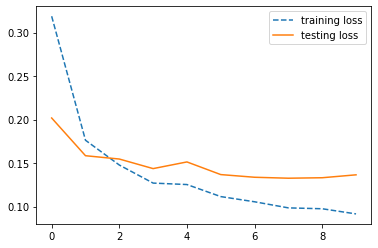

In [58]:

plot(train_loss3,test_loss3)

In [59]:
a41=accuracy(trainloader_minibatch,batchdropoutmlp)
a42=accuracy(testloader,batchdropoutmlp)
print(a41)
print(a42) 

0.973
0.961


In [60]:
train_set_preds,actual_train= make_predictions(trainloader_minibatch,batchdropoutmlp)
test_set_preds,actual_test = make_predictions(testloader,batchdropoutmlp)


from sklearn.metrics import f1_score
f41=f1_score(actual_train, train_set_preds, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn')
f42=f1_score(actual_test, test_set_preds, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn')
print(f41)
print(f42)

0.9904333333333334
0.9775


In [61]:
table = PrettyTable(["Optimizer", "Train Accuracy", "Test Accuracy", "F1 score train", "F1 score test"])
table.align = 'l'
table.add_row(["Simple Adam", a51, a52, f51, f52])
table.add_row(["Adam with Batchnorm", a21, a22, f21, f22])
table.add_row(["Adam with Dropout", a31, a32, f31, f32])
table.add_row(["Adam with Batchnorm and Dropout", a41, a42, f41, f42])

In [62]:
print(table)  

+---------------------------------+----------------+---------------+--------------------+---------------+
| Optimizer                       | Train Accuracy | Test Accuracy | F1 score train     | F1 score test |
+---------------------------------+----------------+---------------+--------------------+---------------+
| Simple Adam                     | 0.987          | 0.97          | 0.9866666666666668 | 0.9695        |
| Adam with Batchnorm             | 0.991          | 0.974         | 0.9949333333333333 | 0.9777        |
| Adam with Dropout               | 0.973          | 0.965         | 0.98765            | 0.9764        |
| Adam with Batchnorm and Dropout | 0.973          | 0.961         | 0.9904333333333334 | 0.9775        |
+---------------------------------+----------------+---------------+--------------------+---------------+


### Step eight: Mini-batch vs Stocastic
Now that you might have a clear winner in your mind regarding which model and settings perform the best, train it on mini-batch and stocastic and compare time taken, loss curve, accuracy etc.

Perform an analysis like never before!


Adam optimizer with simple mlp using ExponentialLR is the best model for given situation.

Mini-Batch Analysis

In [63]:
mlp1=SimpleMLP()
optimizer1 = torch.optim.Adam(mlp1.parameters(), lr=0.003) #e-1
scheduler1 = ExponentialLR(optimizer1, gamma=0.9)

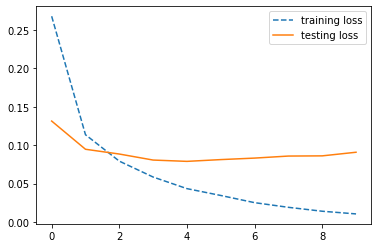

In [64]:
train_loss1,test_loss1,t1=runOptimizer(optimizer1,mlp1,trainloader_minibatch,testloader,scheduler1)
plot(train_loss1,test_loss1)

In [65]:
a11=accuracy(trainloader_minibatch,mlp1)
a12=accuracy(testloader,mlp1)
print(a11)
print(a12)  

0.996
0.978


In [66]:
train_set_preds,actual_train= make_predictions(trainloader_minibatch,mlp1)
test_set_preds,actual_test = make_predictions(testloader,mlp1)


from sklearn.metrics import f1_score
f11=f1_score(actual_train, train_set_preds, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn')
f12=f1_score(actual_test, test_set_preds, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn')
print(f11)
print(f12)

0.9960166666666667
0.9783


In [67]:
print("time taken is ",t1)

time taken is  2.381263307730357


Stochastic analysis

In [68]:
mlp2=SimpleMLP()
optimizer2 = torch.optim.Adam(mlp2.parameters(), lr=0.003) #e-1
scheduler2 = ExponentialLR(optimizer2, gamma=0.9)

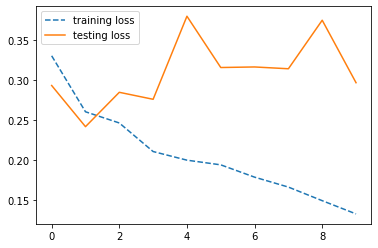

In [69]:
train_loss2,test_loss2,t2=runOptimizer(optimizer2,mlp2,trainloader_stochastic,testloader,scheduler2)
plot(train_loss2,test_loss2)

In [70]:
a21=accuracy(trainloader_stochastic,mlp2)
a22=accuracy(testloader,mlp2)
print(a21)
print(a22) 


0.972
0.956


In [71]:
train_set_preds,actual_train= make_predictions(trainloader_stochastic,mlp2)
test_set_preds,actual_test = make_predictions(testloader,mlp2)


from sklearn.metrics import f1_score
f21=f1_score(actual_train, train_set_preds, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn')
f22=f1_score(actual_test, test_set_preds, labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn')
print(f21)
print(f22)

0.9723
0.9555


In [72]:
print("time taken is ",t2)

time taken is  68.85275229215623


In [73]:
table = PrettyTable(["Optimizer", "Train Accuracy", "Test Accuracy", "F1 score train", "F1 score test","Time Taken"])
table.align = 'l'
table.add_row(["Mini-Batch", a11, a12, f11, f12,t1])
table.add_row(["Stochastic", a21, a22, f21, f22,t2])


In [74]:
print(table)

+------------+----------------+---------------+--------------------+---------------+-------------------+
| Optimizer  | Train Accuracy | Test Accuracy | F1 score train     | F1 score test | Time Taken        |
+------------+----------------+---------------+--------------------+---------------+-------------------+
| Mini-Batch | 0.996          | 0.978         | 0.9960166666666667 | 0.9783        | 2.381263307730357 |
| Stochastic | 0.972          | 0.956         | 0.9723             | 0.9555        | 68.85275229215623 |
+------------+----------------+---------------+--------------------+---------------+-------------------+


Using a stochastic dataloader for training can be a time-consuming process due to the batch_size being set to 1.Mini Batch is performing better than stochastic for accuracy and F1 score.

### And most importantly!!! What did we learn?
Discuss any and all learnings here. The discussions must be all-encompassing so that we know what did you learn. 

Please do not copy from your friend or copy-paste from the internet. We can see repetitions during evaluations.

In [75]:
# text here

Due to the dataset size of 70k (60k trainset + 10k testset), it is difficult for me to find the distinctions between various optimizers. Although I have observed some variations in performance using the Adam optimizer.
In case of LR schedulers differences are minute,but I have chosen ExponentialLR for step-8 .We can't use batch normalization on trainloader_stochastic because of batch size is 1.